<a href="https://colab.research.google.com/github/stokkangri/ERAV4/blob/main/S4_Assignment/ERA_V4_Session_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

CODE BLOCK: 1

In [114]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

CODE BLOCK: 2

In [115]:
# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

CUDA Available? True


CODE BLOCK: 3

In [116]:
# Train data transformations
train_transforms = transforms.Compose([
    transforms.RandomApply([transforms.CenterCrop(22), ], p=0.1),
    transforms.Resize((28, 28)),
    transforms.RandomRotation((-15., 15.), fill=0),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,)),
    ])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1407,), (0.4081,))
    ])

CODE BLOCK: 4

In [117]:
train_data = datasets.MNIST('../data', train=True, download=True, transform=train_transforms)
test_data = datasets.MNIST('../data', train=False, download=True, transform=train_transforms)

CODE BLOCK: 5

In [118]:
batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': False, 'num_workers': 2, 'pin_memory': True}

test_loader = torch.utils.data.DataLoader(test_data, **kwargs)
train_loader = torch.utils.data.DataLoader(train_data, **kwargs)

CODE BLOCK: 6

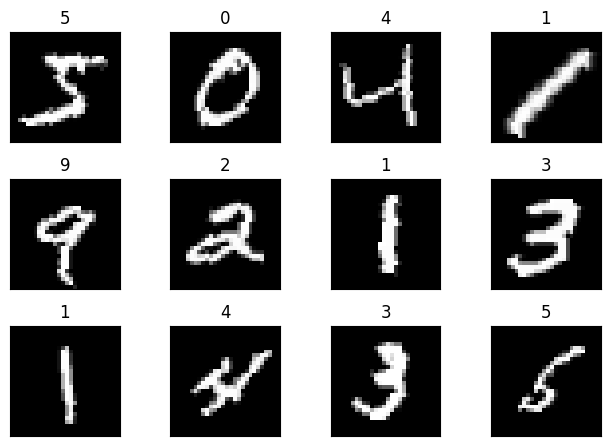

In [119]:
import matplotlib.pyplot as plt

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  plt.imshow(batch_data[i].squeeze(0), cmap='gray')
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

CODE BLOCK: 7

In [120]:
class Net_org(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3)
        self.conv4 = nn.Conv2d(128, 256, kernel_size=3)
        self.fc1 = nn.Linear(4096, 50) # Updated input size based on summary
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(self.conv3(x))
        x = F.relu(F.max_pool2d(self.conv4(x), 2))
        x = x.view(-1, 4096) # Updated flatten size based on summary
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

In [121]:
class Net(nn.Module):
    #This defines the structure of the NN.
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3)
        self.bn1 = nn.BatchNorm2d(16)
        self.dropout1 = nn.Dropout(0.01)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3) # Corrected input channels to match conv1 output
        self.bn2 = nn.BatchNorm2d(32)
        self.dropout2 = nn.Dropout(0.01)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3) # Corrected input channels to match conv2 output
        self.bn3 = nn.BatchNorm2d(64) # Corrected BatchNorm channels to match conv3 output
        self.dropout3 = nn.Dropout(0.01)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3) # Corrected input channels to match conv3 output
        self.bn4 = nn.BatchNorm2d(128) # Corrected BatchNorm channels to match conv4 output
        self.dropout4 = nn.Dropout(0.01)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3) # Corrected input channels to match conv3 output
        self.bn5 = nn.BatchNorm2d(256) # Corrected BatchNorm channels to match conv4 output
        self.dropout5 = nn.Dropout(0.01)
        self.conv1x1_256 = nn.Conv2d(256, 32, kernel_size=1) # Changed to 1x1 convolution and output channels to 10 for GAP
        self.conv1x1_128 = nn.Conv2d(128, 32, kernel_size=1) # Changed to 1x1 convolution and output channels to 10 for GAP
        self.fc1 = nn.Linear(32, 10) # Updated input size based on summary
        self.global_avg_pool = nn.AdaptiveAvgPool2d(1) # Added Global Average Pooling

    def forward(self, x):
        x = self.dropout1(F.relu(self.bn1(self.conv1(x))))
        x = self.dropout2(F.relu(self.bn2(self.conv2(x))))
        x = F.max_pool2d(x, 2) # Apply max pooling after conv2 block
        x = self.dropout3(F.relu(self.bn3(self.conv3(x))))
        x = self.dropout4(F.relu(self.bn4(self.conv4(x))))
        x = F.max_pool2d(x, 2) # Apply max pooling after conv4 block
        #x = self.dropout5(F.relu(self.bn5(self.conv5(x))))
        #x = self.conv1x1_256(x) # Apply 1x1 convolution
        x = self.conv1x1_128(x) # Apply 1x1 convolution
        x = self.global_avg_pool(x) # Apply Global Average Pooling
        x = x.view(-1, 32) # Flatten for the final output
        x = self.fc1(x)
        return F.log_softmax(x, dim=1)

CODE BLOCK: 8

In [122]:
# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_acc = []
test_acc = []

test_incorrect_pred = {'images': [], 'ground_truths': [], 'predicted_vals': []}

CODE BLOCK: 9

In [123]:
from tqdm import tqdm

def GetCorrectPredCount(pPrediction, pLabels):
  return pPrediction.argmax(dim=1).eq(pLabels).sum().item()

def train(model, device, train_loader, optimizer, criterion):
  model.train()
  pbar = tqdm(train_loader)

  train_loss = 0
  correct = 0
  processed = 0

  for batch_idx, (data, target) in enumerate(pbar):
    data, target = data.to(device), target.to(device)
    optimizer.zero_grad()

    # Predict
    pred = model(data)

    # Calculate loss
    loss = criterion(pred, target)
    train_loss+=loss.item()

    # Backpropagation
    loss.backward()
    optimizer.step()

    correct += GetCorrectPredCount(pred, target)
    processed += len(data)

    pbar.set_description(desc= f'Train: Loss={loss.item():0.4f} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')

  train_acc.append(100*correct/processed)
  train_losses.append(train_loss/len(train_loader))

def test(model, device, test_loader, criterion):
    model.eval()

    test_loss = 0
    correct = 0

    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)

            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss

            correct += GetCorrectPredCount(output, target)


    test_loss /= len(test_loader.dataset)
    test_acc.append(100. * correct / len(test_loader.dataset))
    test_losses.append(test_loss)

    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

CODE BLOCK: 10

In [109]:
!pip install torchsummary
from torchsummary import summary





In [124]:
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
       BatchNorm2d-2           [-1, 16, 26, 26]              32
           Dropout-3           [-1, 16, 26, 26]               0
            Conv2d-4           [-1, 32, 24, 24]           4,640
       BatchNorm2d-5           [-1, 32, 24, 24]              64
           Dropout-6           [-1, 32, 24, 24]               0
            Conv2d-7           [-1, 64, 10, 10]          18,496
       BatchNorm2d-8           [-1, 64, 10, 10]             128
           Dropout-9           [-1, 64, 10, 10]               0
           Conv2d-10            [-1, 128, 8, 8]          73,856
      BatchNorm2d-11            [-1, 128, 8, 8]             256
          Dropout-12            [-1, 128, 8, 8]               0
           Conv2d-13             [-1, 32, 4, 4]           4,128
AdaptiveAvgPool2d-14             [-1, 3

In [125]:
optimizer = optim.SGD(model.parameters(), lr=0.15, momentum=0.9)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1) #, verbose=True)
# New Line
criterion = nn.CrossEntropyLoss()
num_epochs = 2

for epoch in range(1, num_epochs+1):
  print(f'Epoch {epoch}')
  train(model, device, train_loader, optimizer, criterion)
  test(model, device, train_loader, criterion)
  scheduler.step()

Epoch 1


Train: Loss=0.1489 Batch_id=117 Accuracy=84.63: 100%|██████████| 118/118 [00:17<00:00,  6.79it/s]


Test set: Average loss: 0.0003, Accuracy: 57376/60000 (95.63%)

Epoch 2


Train: Loss=0.2063 Batch_id=117 Accuracy=97.08: 100%|██████████| 118/118 [00:18<00:00,  6.55it/s]


Test set: Average loss: 0.0003, Accuracy: 57221/60000 (95.37%)



CODE BLOCK: 11

Text(0.5, 1.0, 'Test Accuracy')

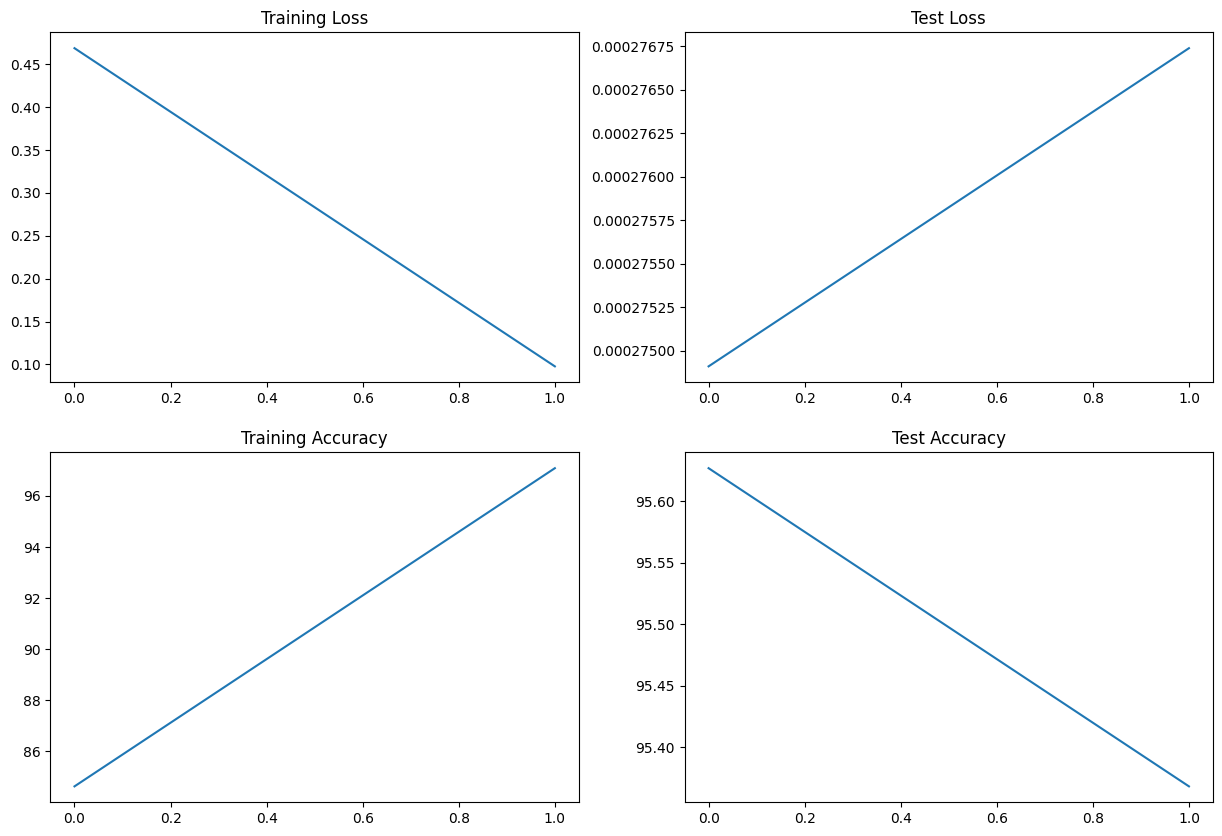

In [126]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

# MNIST Classifier with a Convolutional Neural Network

This notebook demonstrates a simple Convolutional Neural Network (CNN) for classifying handwritten digits from the MNIST dataset using PyTorch.

## Network Architecture (`Class Net`)

The neural network is defined in the `Net` class. It consists of the following layers:

- **Convolutional Layer 1 (`conv1`):** Takes a single input channel (grayscale MNIST images) and applies 16 filters with a kernel size of 3x3.
- **Batch Normalization 1 (`bn1`):** Normalizes the output of `conv1`.
- **Dropout 1 (`dropout1`):** Applies dropout with a probability of 0.01 to the output of the first batch normalization layer.
- **Convolutional Layer 2 (`conv2`):** Takes 16 input channels (from `conv1`) and applies 32 filters with a kernel size of 3x3.
- **Batch Normalization 2 (`bn2`):** Normalizes the output of `conv2`.
- **Dropout 2 (`dropout2`):** Applies dropout with a probability of 0.01 to the output of the second batch normalization layer.
- **Max Pooling 1:** Applies a 2x2 max pooling operation after the second convolutional block to reduce spatial dimensions.
- **Convolutional Layer 3 (`conv3`):** Takes 32 input channels (from the previous block) and applies 64 filters with a kernel size of 3x3.
- **Batch Normalization 3 (`bn3`):** Normalizes the output of `conv3`.
- **Dropout 3 (`dropout3`):** Applies dropout with a probability of 0.01 to the output of the third batch normalization layer.
- **Convolutional Layer 4 (`conv4`):** Takes 64 input channels (from the previous block) and applies 128 filters with a kernel size of 3x3.
- **Batch Normalization 4 (`bn4`):** Normalizes the output of `conv4`.
- **Dropout 4 (`dropout4`):** Applies dropout with a probability of 0.01 to the output of the fourth batch normalization layer.
- **Max Pooling 2:** Applies a 2x2 max pooling operation after the fourth convolutional block to further reduce spatial dimensions.
- **1x1 Convolution (`conv1x1`):** Applies a 1x1 convolution with 10 output channels. This is often used to reduce the number of channels before global average pooling.
- **Global Average Pooling (`global_avg_pool`):** Applies global average pooling to reduce the spatial dimensions to 1x1, effectively averaging the feature maps.
- **Flatten:** The output is flattened into a 1D tensor with 10 elements (corresponding to the 10 classes).
- **Log Softmax:** Applies the log-softmax function to the output, providing log-probabilities for each class.

The `forward` method defines the flow of data through these layers, applying ReLU activation functions after each convolutional and batch normalization step. Dropout is applied after the batch normalization layers. Max pooling is applied after the second and fourth convolutional blocks. A 1x1 convolution and global average pooling are used before the final output.

## Training Logs

The notebook includes a training loop that trains the model for a specified number of epochs. The `train` function iterates over the training data, calculates the loss, and updates the model's weights using an optimizer. The `test` function evaluates the model's performance on the test data after each epoch.

Here are some of the logs observed during the training:

- **CUDA Availability:** The notebook checks for CUDA availability, indicating whether the training will run on a GPU (if available) or CPU.
- **Model Summary:** The `torchsummary` library is used to print a summary of the model, showing the output shape and number of parameters for each layer. This helps in understanding the model's structure and parameter count.
- **Training Progress (tqdm):** The `tqdm` library is used to display a progress bar during training, showing the current batch loss, batch ID, and training accuracy.
- **Test Set Evaluation:** After each epoch, the model is evaluated on the test set, and the average loss and accuracy are printed.

The notebook also includes code to plot the training and testing loss and accuracy over epochs, providing a visual representation of the model's learning progress.

**Note:** The logs in this notebook are based on the execution of the code and may vary depending on the specific runtime environment and hyperparameters used.